--- Client Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  for

/tmp/ipython-input-876449028.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=client_df, x='churn', palette='Set2')



EDA completed. Images saved to current directory.


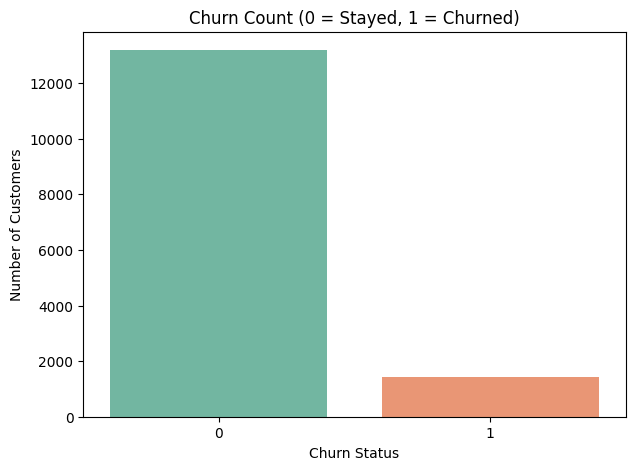

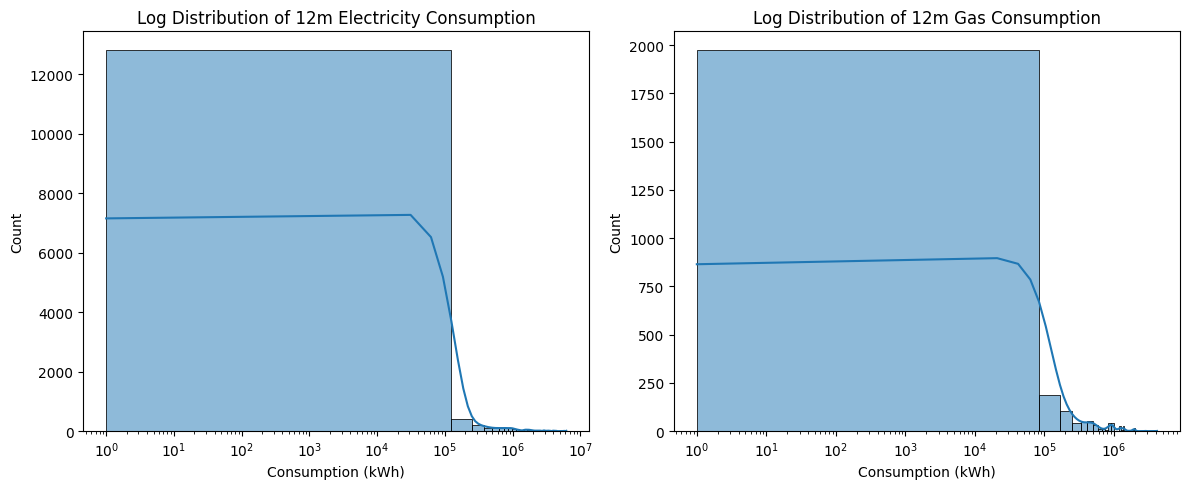

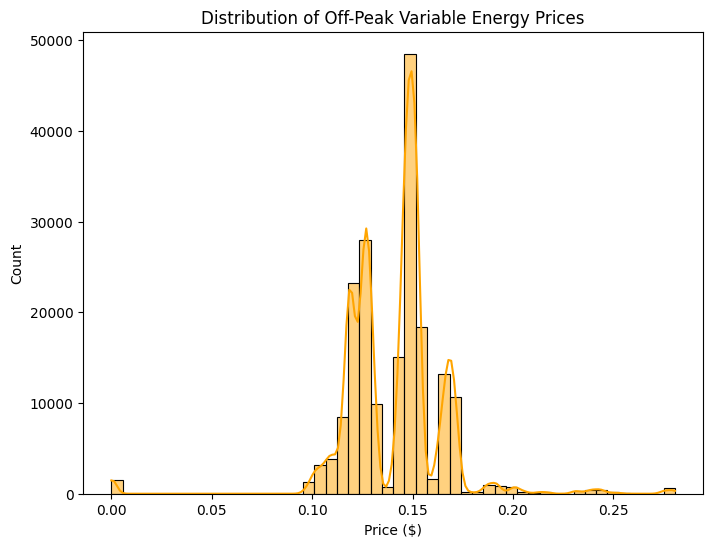

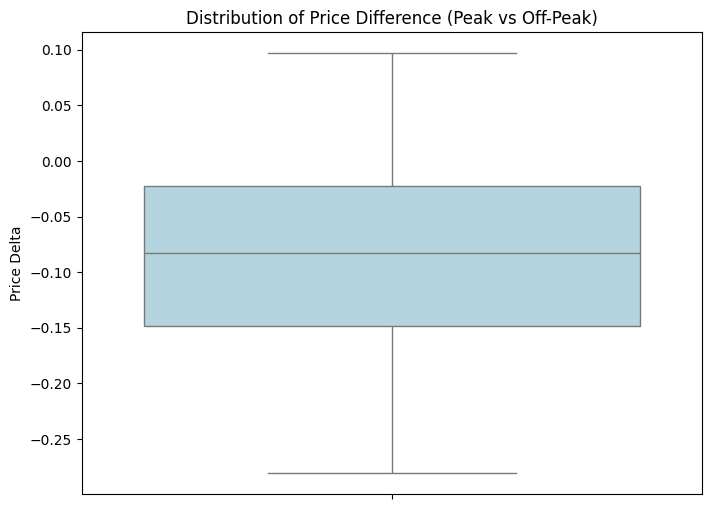

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the datasets
client_df = pd.read_csv('client_data (1).csv')
price_df = pd.read_csv('price_data (1).csv')

# 2. Analyze Data Types and Structure
print("--- Client Data Overview ---")
print(client_df.info())
print("\n--- Price Data Overview ---")
print(price_df.info())

# 3. Descriptive Statistics
print("\n--- Client Data Summary Statistics ---")
print(client_df.describe())

# 4. Data Cleaning: Convert date columns to datetime
date_cols = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
for col in date_cols:
    client_df[col] = pd.to_datetime(client_df[col])
price_df['price_date'] = pd.to_datetime(price_df['price_date'])

# 5. Visualizing Distributions

# A. Churn Distribution (The target variable)
plt.figure(figsize=(7, 5))
sns.countplot(data=client_df, x='churn', palette='Set2')
plt.title('Churn Count (0 = Stayed, 1 = Churned)')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.savefig('churn_distribution.png')

# B. Consumption Distributions (Logged to handle high skewness)
# Note: Adding 1 to avoid log(0)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(client_df['cons_12m'] + 1, kde=True, bins=50)
plt.xscale('log')
plt.title('Log Distribution of 12m Electricity Consumption')
plt.xlabel('Consumption (kWh)')

plt.subplot(1, 2, 2)
sns.histplot(client_df[client_df['has_gas'] == 't']['cons_gas_12m'] + 1, kde=True, bins=50)
plt.xscale('log')
plt.title('Log Distribution of 12m Gas Consumption')
plt.xlabel('Consumption (kWh)')

plt.tight_layout()
plt.savefig('consumption_histograms.png')

# C. Price Distribution (Off-peak variable prices)
plt.figure(figsize=(8, 6))
sns.histplot(price_df['price_off_peak_var'], bins=50, color='orange', kde=True)
plt.title('Distribution of Off-Peak Variable Energy Prices')
plt.xlabel('Price ($)')
plt.savefig('price_var_distribution.png')

# 6. Initial Price Sensitivity Insight
# Checking the difference between off-peak and peak energy prices
price_df['diff_peak_off_peak'] = price_df['price_peak_var'] - price_df['price_off_peak_var']

plt.figure(figsize=(8, 6))
sns.boxplot(y=price_df['diff_peak_off_peak'], color='lightblue')
plt.title('Distribution of Price Difference (Peak vs Off-Peak)')
plt.ylabel('Price Delta')
plt.savefig('price_delta_boxplot.png')

print("\nEDA completed. Images saved to current directory.")

In [3]:
import pandas as pd
import numpy as np

# Load datasets
client_df = pd.read_csv('client_data (1).csv')
price_df = pd.read_csv('price_data (1).csv')

# Convert dates to datetime objects
date_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
for col in date_columns:
    client_df[col] = pd.to_datetime(client_df[col])
price_df['price_date'] = pd.to_datetime(price_df['price_date'])

# --- 1. Fixed Tenure & Duration Calculations ---
# Using the latest activation date as a reference point for tenure
reference_date = client_df['date_activ'].max()

# Calculate tenure in years (using days / 365.25 to avoid ambiguity error)
client_df['tenure_years'] = ((reference_date - client_df['date_activ']).dt.days / 365.25).astype(int)

# Calculate contract duration in months (using days / 30.44)
client_df['contract_duration_months'] = ((client_df['date_end'] - client_df['date_activ']).dt.days / 30.44).astype(int)

# --- 2. Price Feature Engineering ---
# Difference between off-peak and peak variable prices
price_df['diff_off_peak_peak_var'] = price_df['price_off_peak_var'] - price_df['price_peak_var']

# Aggregate price data per customer
agg_price = price_df.groupby('id').agg({
    'price_off_peak_var': ['mean', 'min', 'max'],
    'price_peak_var': ['mean', 'min', 'max'],
    'diff_off_peak_peak_var': ['mean']
}).reset_index()

# Flatten the multi-level column names
agg_price.columns = ['_'.join(col).strip('_') for col in agg_price.columns.values]

# Calculate Price Range (capturing price volatility/shocks)
agg_price['price_off_peak_var_range'] = agg_price['price_off_peak_var_max'] - agg_price['price_off_peak_var_min']

# --- 3. Additional Features ---
client_df['is_dual_fuel'] = client_df['has_gas'].apply(lambda x: 1 if x == 't' else 0)
client_df['total_cons_12m'] = client_df['cons_12m'] + client_df['cons_gas_12m']

# --- 4. Merge and Final Cleanup ---
df_featured = pd.merge(client_df, agg_price, on='id', how='left')

# Drop raw dates now that we have tenure and duration
df_featured = df_featured.drop(columns=['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])

# Save the final featured dataset
df_featured.to_csv('featured_data.csv', index=False)

print("Feature engineering complete. File saved as 'featured_data.csv'.")

Feature engineering complete. File saved as 'featured_data.csv'.


--- Model Evaluation ---
Accuracy:  0.9086
Precision: 0.7742
Recall:    0.0845
F1 Score:  0.1524

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2638
           1       0.77      0.08      0.15       284

    accuracy                           0.91      2922
   macro avg       0.84      0.54      0.55      2922
weighted avg       0.90      0.91      0.87      2922



/tmp/ipython-input-109471659.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='magma')



Modeling complete. Images saved to directory.


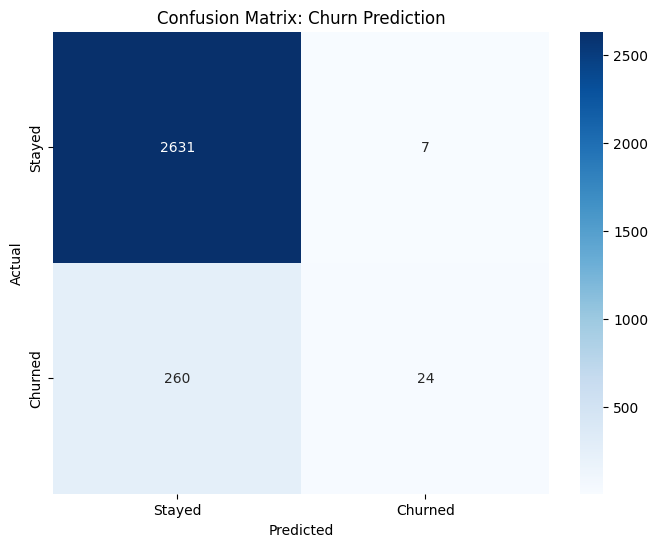

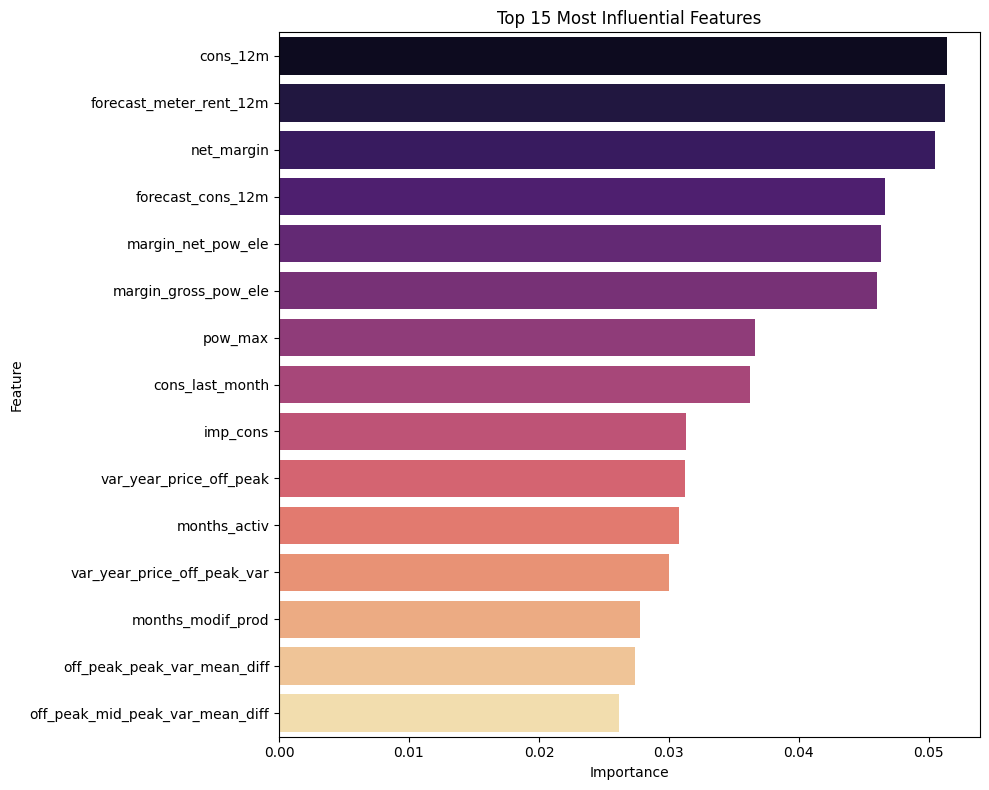

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# 1. Load the finalized dataset provided by Estelle
df = pd.read_csv('data_for_predictions.csv')

# 2. Data Preparation
# Drop identification columns that aren't useful for the model
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Store ID separately if needed, then drop from training data
ids = df['id']
X = df.drop(columns=['id', 'churn'])
y = df['churn']

# 3. Split into training and testing sets (80% train, 20% test)
# We use 'stratify=y' because the dataset is imbalanced (only ~10% churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 4. Model Training: Random Forest Classifier
# We increase n_estimators for stability and use random_state for reproducibility
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Model Prediction
y_pred = rf_model.predict(X_test)

# 6. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"--- Model Evaluation ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Visualizations

# A. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Churn Prediction')
plt.savefig('churn_confusion_matrix.png')

# B. Feature Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='magma')
plt.title('Top 15 Most Influential Features')
plt.tight_layout()
plt.savefig('feature_importance_modeling.png')

print("\nModeling complete. Images saved to directory.")